# EDA 

На данном этапе загрузим данные, посмотрим, что они из себя представляют, что содержат и какие выводы можно из этого сделать

In [110]:
from collections import Counter
from pathlib import Path
import sys

import IPython
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import pandas as pd
from scipy.signal import wiener
import torchaudio

sys.path.append("../src")

from config import AUDIO_FILES_DIR, DATA_DIR, SEED

np.random.seed(SEED)

## Загрузка

In [ ]:
def load_files(folder_path):
    folder = Path(folder_path)
    variables = {}

    for file_path in folder.glob("*.csv"):
        var_name = file_path.stem
        variables[var_name] = pd.read_csv(file_path)
        print(f"{var_name} downloaded")

    return variables

In [112]:
data = load_files(DATA_DIR / "raw")

test downloaded
train downloaded


## Обзор данных

In [113]:
display(data["train"].head(), data["test"].head())

id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ

id
0  30001.opus
1  30002.opus
2  30003.opus
3  30004.opus
4  30005.opus

In [114]:
data["train"].shape, data["test"].shape

((30000, 2), (5000, 1))

### Обзор звуковых файлов

Загрузим и послушаем несколько записей из датасета

In [115]:
sample = np.random.randint(low=0, high=30000, size=3)
sample_train = data["train"]["id"][sample]
sound_exmpls = {}

for i in sample_train:
    sound_exmpls[i[:-5]], sr = librosa.load(AUDIO_FILES_DIR.joinpath(i), sr=8000)
    print(i, "sr =", sr)
    display(IPython.display.Audio(sound_exmpls[i[:-5]], rate=sr))

15152.opus sr = 8000


15932.opus sr = 8000


19367.opus sr = 8000


Посмотрим как выглядят эти записи в Wave_form, и как выглядят их спектрограммы

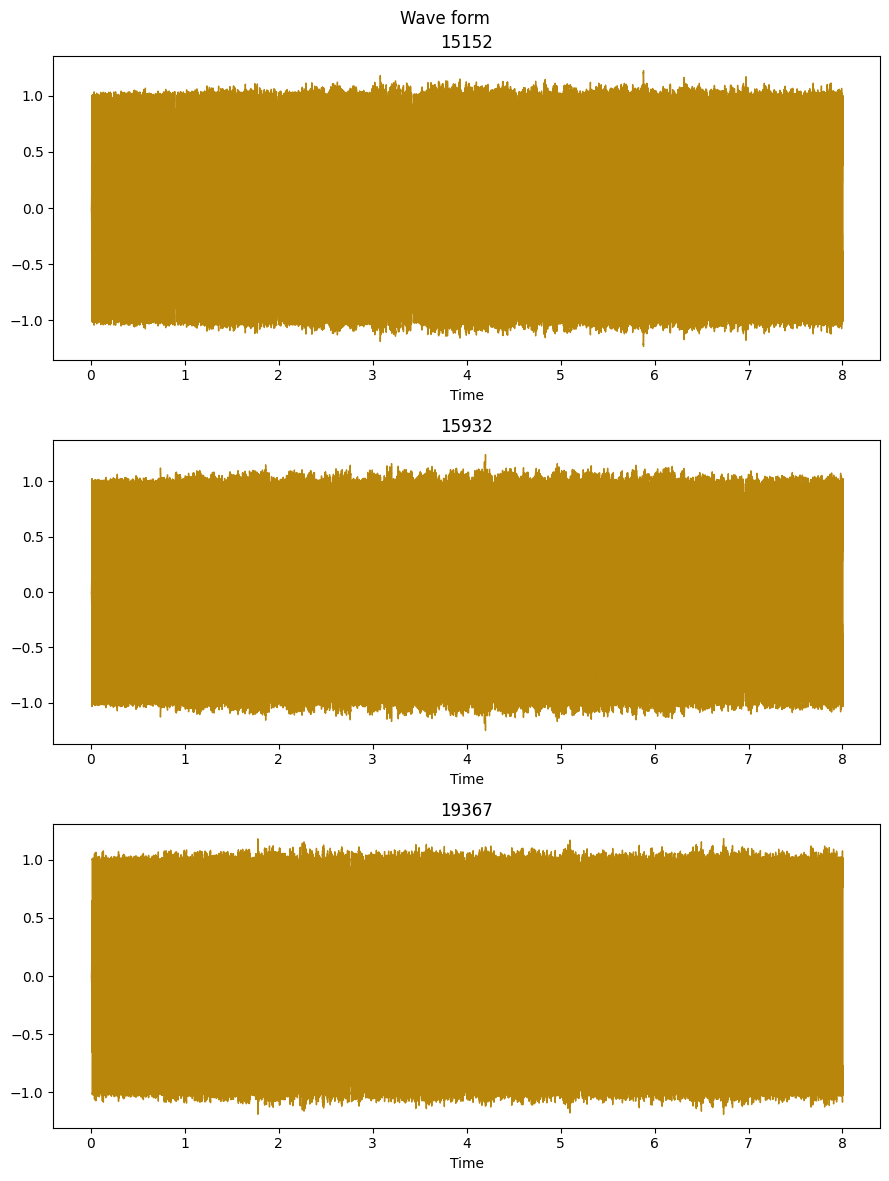

In [116]:
fig, axs = plt.subplots(3, 1, figsize=(9, 12))
fig.suptitle("Wave form")
i = 0

for key, value in sound_exmpls.items():
    ax = axs[i]
    ld.waveshow(value, sr=sr, ax=ax, color="darkgoldenrod")
    ax.set_title(key)
    i += 1

fig.tight_layout()
plt.show()

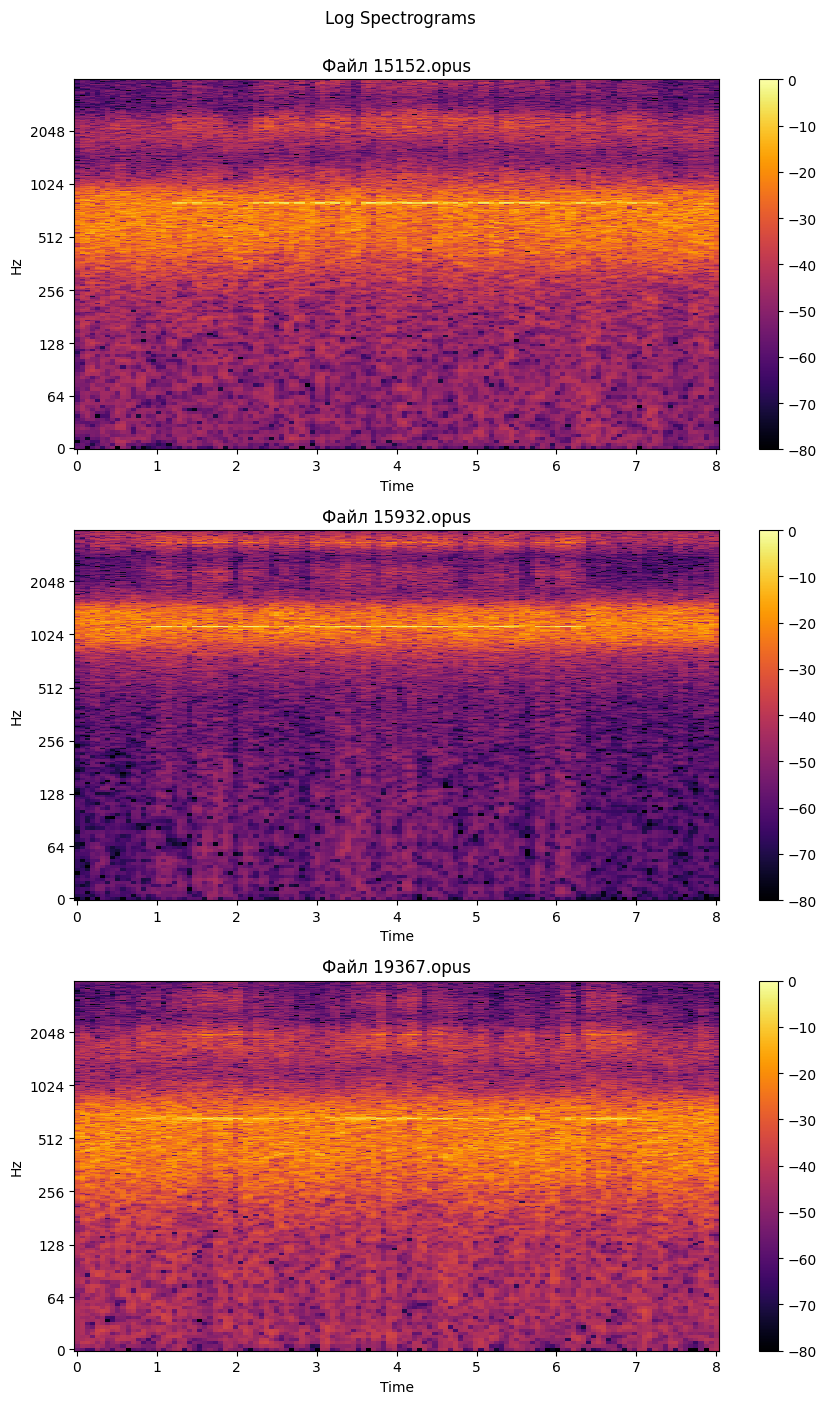

In [117]:
fig, axs = plt.subplots(3, 1, figsize=(9, 14))
fig.suptitle("Log Spectrograms", x=0.45, y=1)
cmap = "inferno"

for i, (key, value) in enumerate(sound_exmpls.items()):
    ax = axs[i]

    D = np.abs(librosa.stft(value))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    img = librosa.display.specshow(
        DB, sr=sr, x_axis="time", y_axis="log", ax=ax, cmap=cmap, fmax=8000
    )
    fig.colorbar(img, ax=ax)
    ax.set_title(f"Файл {key}.opus")

fig.tight_layout()
plt.show()

Проверим длительности всех записей

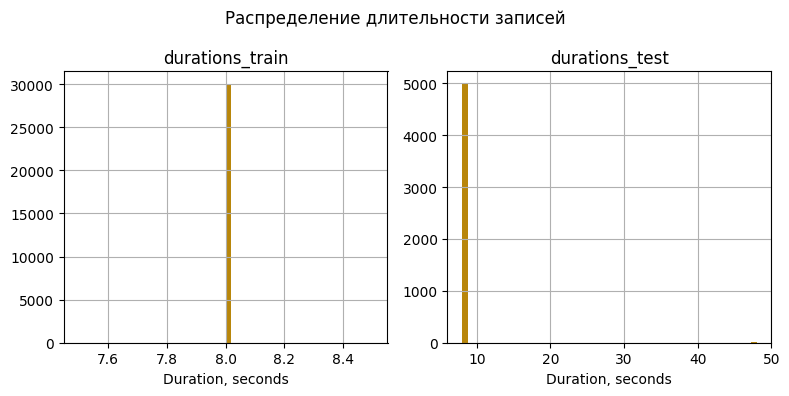

In [118]:
durations_train = pd.Series(
    [
        librosa.get_duration(path=AUDIO_FILES_DIR.joinpath(path))
        for path in data["train"]["id"]
    ],
    name="durations_train",
)
durations_test = pd.Series(
    [
        librosa.get_duration(path=AUDIO_FILES_DIR.joinpath(path))
        for path in data["test"]["id"]
    ],
    name="durations_test",
)

fig, axs = plt.subplots(1, 2)
fig.suptitle("Распределение длительности записей")
fig.set_figheight(4)
fig.set_figwidth(8)

for i, dur in enumerate([durations_train, durations_test]):
    ax = axs[i]
    ax.hist(dur, bins=50, color="darkgoldenrod")
    ax.set_xlabel("Duration, seconds")
    ax.set_title(dur.name)
    ax.grid(True)

fig.tight_layout()

### Целевой признак `message`

Посмотрим какой длины могут быть закодированные сообщения

In [119]:
pd.Series((len(x) for x in data["train"].message)).describe()

count    30000.000000
mean         8.916833
std          1.561793
min          4.000000
25%          8.000000
50%          9.000000
75%         10.000000
max         14.000000
dtype: float64

Построим распределение всех символов из целевого признака

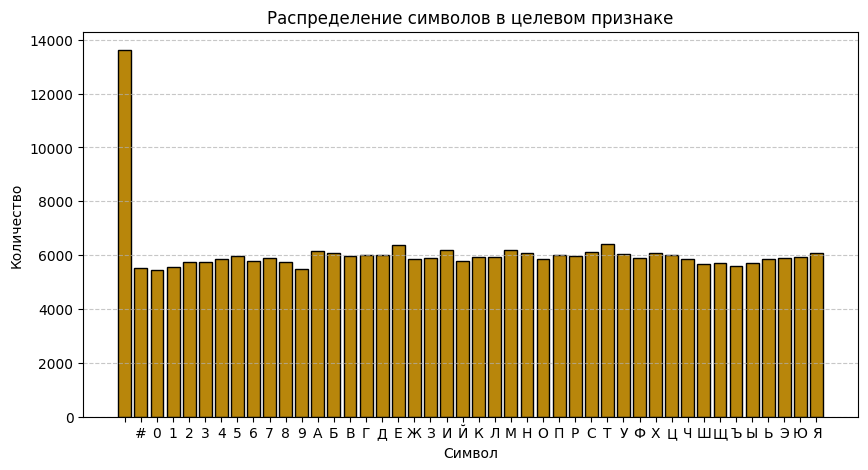

In [120]:
all_chars = "".join(data["train"]["message"])

char_counts = Counter(all_chars)
sorted_counts = dict(
    sorted(char_counts.items(), key=lambda item: item[0], reverse=False)
)

plt.figure(figsize=(10, 5))
plt.bar(
    sorted_counts.keys(),
    sorted_counts.values(),
    color="darkgoldenrod",
    edgecolor="black",
)
plt.title("Распределение символов в целевом признаке")
plt.xlabel("Символ")
plt.ylabel("Количество")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Краткие выводы

У нас имеется обучающий датасет, содержащий 30 000 аудиофайлов в формате .opus. В каждом из них зашифрована бессмысленная последовательность символов, <br>
включающая русские буквы, цифры, пробел и символ #.  <br>
В целом распределение целевых символов в датасете достаточно равномерное, за исключением пробела — его доля заметно выше.

Аудиофайлы представляют собой записи передачи информации с помощью азбуки Морзе.  <br>
Почти все записи имеют одинаковую продолжительность — ровно 8 секунд, за исключением 17 файлов, чья длина составляет около 50 секунд, что оговорено в условиях задачи.

Анализ спектрограмм показал, что в пределах одного файла звуковой сигнал передаётся на одной частоте,  <br>
однако эта частота может различаться между разными примерами. <br>
Целевой сигнал визуально различим на мел-спектрограммах, но сопровождается значительным количеством шумов и отражений на других частотах, <br>
что может затруднять точное распознавание.

## Варианты обработки сигналов

### Мел спектрограммы

Посмотрим, как визуально отображается сигнал на мел-спектрограммах.

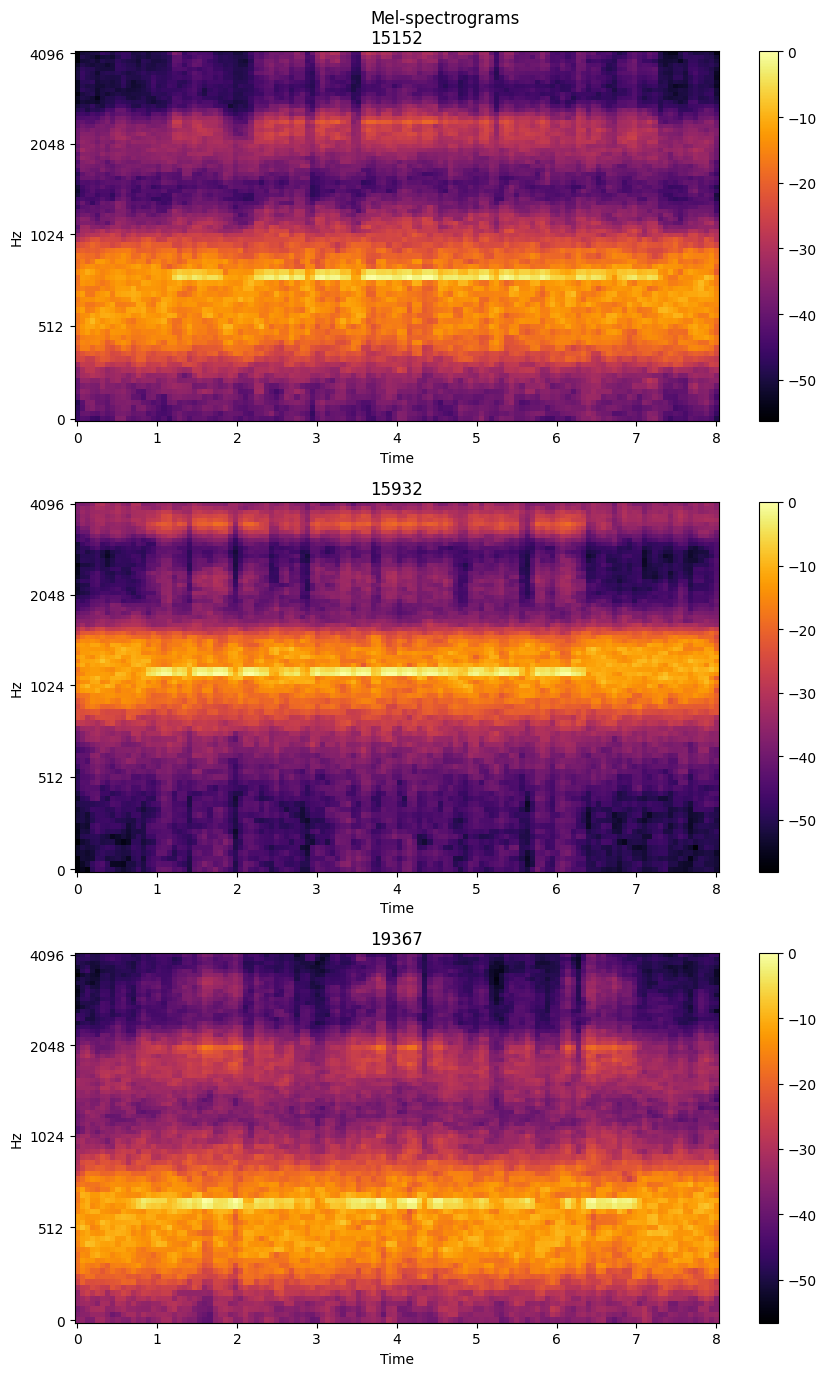

In [121]:
fig, axs = plt.subplots(3, 1, figsize=(9, 14))
fig.suptitle("Mel-spectrograms")
cmap = "inferno"

for i, (key, value) in enumerate(sound_exmpls.items()):
    ax = axs[i]

    S = librosa.feature.melspectrogram(y=value, sr=sr, n_mels=80, fmax=4096)
    S_dB = librosa.power_to_db(S, ref=np.max)

    img = ld.specshow(
        S_dB, sr=sr, x_axis="time", y_axis="mel", ax=ax, fmax=4096, cmap=cmap
    )
    fig.colorbar(img, ax=ax)
    ax.set_title(key)

fig.tight_layout()
plt.show()

Визуально сигнал становится ярче, и глазами четче отделен от шума. 

**Для модели baseline будем использовать простые мел-спектрограммы, чтобы получить результат, на который можно ориентироваться**

### Очиста от шума инструментами wiener и noisereduce

Для последующего улучшения качества сигнала попробуем снизить уровень шума с помощью готовых инструментов: фильтра Винера из библиотеки `scipy.signal`, а также библиотеки `noisereduce`.

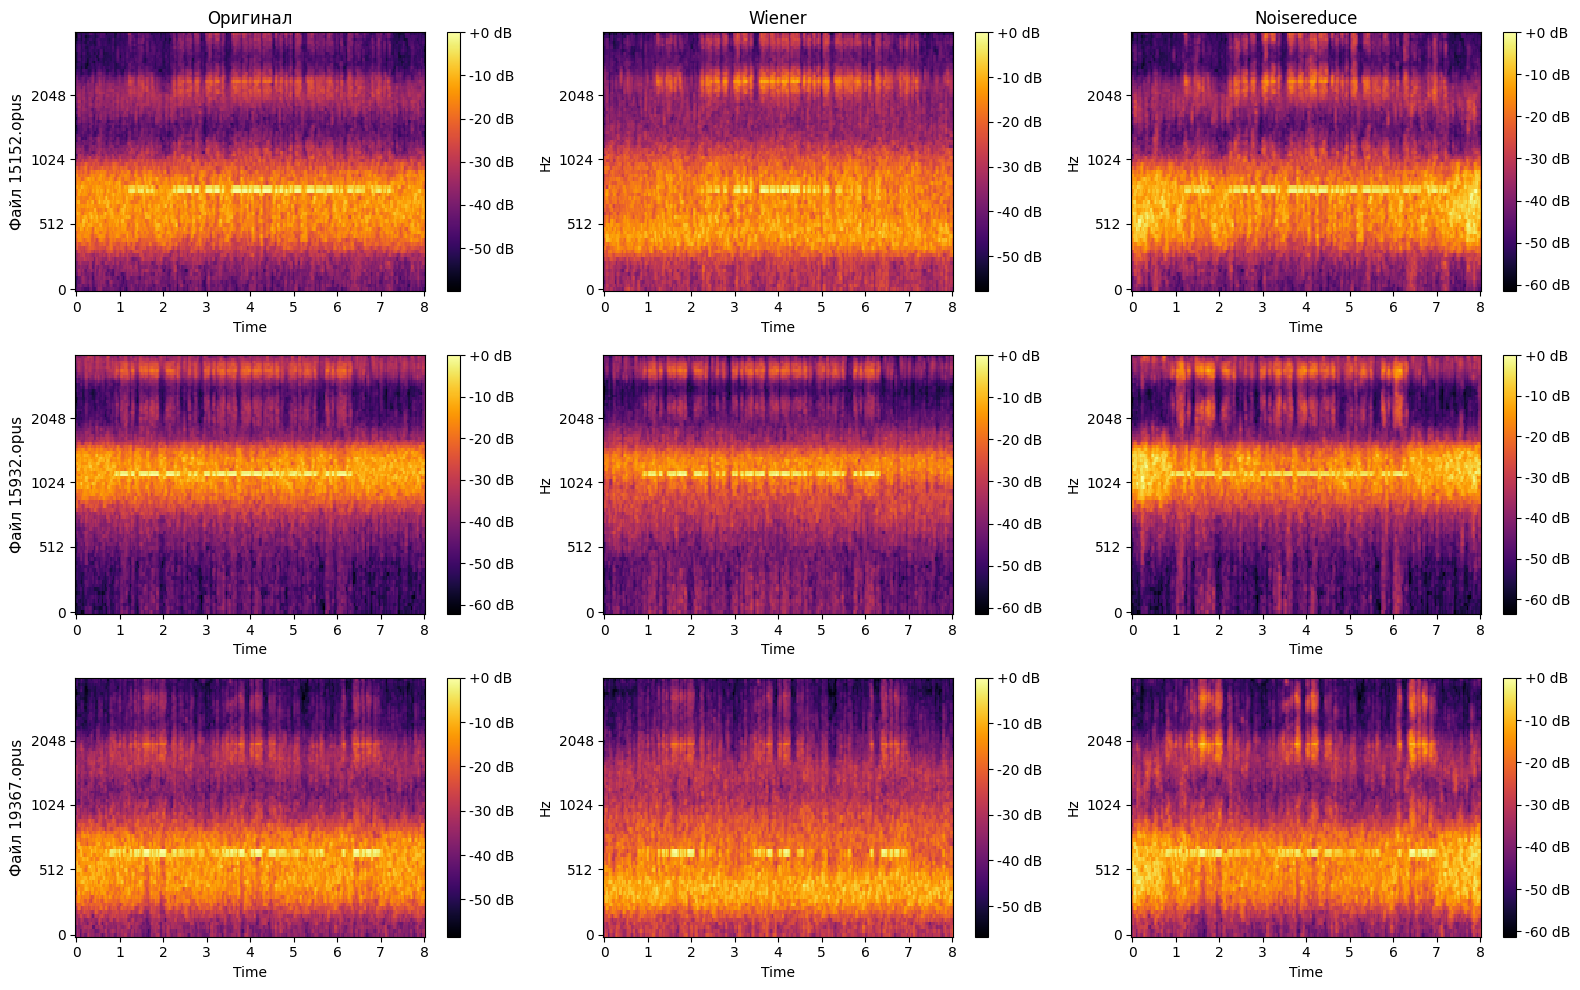

In [122]:
titles = ["Оригинал", "Wiener", "Noisereduce"]

plt.figure(figsize=(16, 10))

for row, (key, y) in enumerate(sound_exmpls.items()):
    y_wiener = wiener(y, mysize=15)
    y_nr = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.89)
    for col, y_sig in enumerate([y, y_wiener, y_nr]):
        idx = row * 3 + col + 1
        plt.subplot(3, 3, idx)
        S = librosa.feature.melspectrogram(
            y=y_sig, sr=sr, n_fft=1024, hop_length=256, n_mels=80, fmax=4096
        )
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(
            S_dB, sr=sr, hop_length=256, x_axis="time", y_axis="mel", cmap=cmap
        )

        if row == 0:
            plt.title(titles[col], fontsize=12)

        if col == 0:
            plt.ylabel(f"Файл {key}.opus", fontsize=11)

        plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()

По графикам заметно, что при использовании фильтра Винера сигнал становится более чистым, а фоновый шум лучше подавляется.  <br>
В процессе я перебрал несколько параметров фильтрации, чтобы добиться наиболее заметного эффекта без потери полезной информации.  <br>
**В дальнейшем попробуем применить предобработку фильтром Винера и оценим, как она повлияет на поведение модели при обучении.**

### Экспоненциальное усиление сигналов

По спектрограммам можно заметить, что целевой сигнал является самым громким звуком на записях, в то время как окружающий шум в большинстве случаев тише.  <br>
Основываясь на этом, попробуем экспоненциально усилить сигналы, возведя значения в степень, а затем нормализуем результат. <br>
После этого визуализируем полученные спектрограммы и оценим эффект от такого усиления.<br>
Дополнительно, в этом этапе мы уменьшаем размер окна и шаг при построении мел-спектрограммы, чтобы повысить временное разрешение и улучшить визуальную чёткость целевого сигнала.

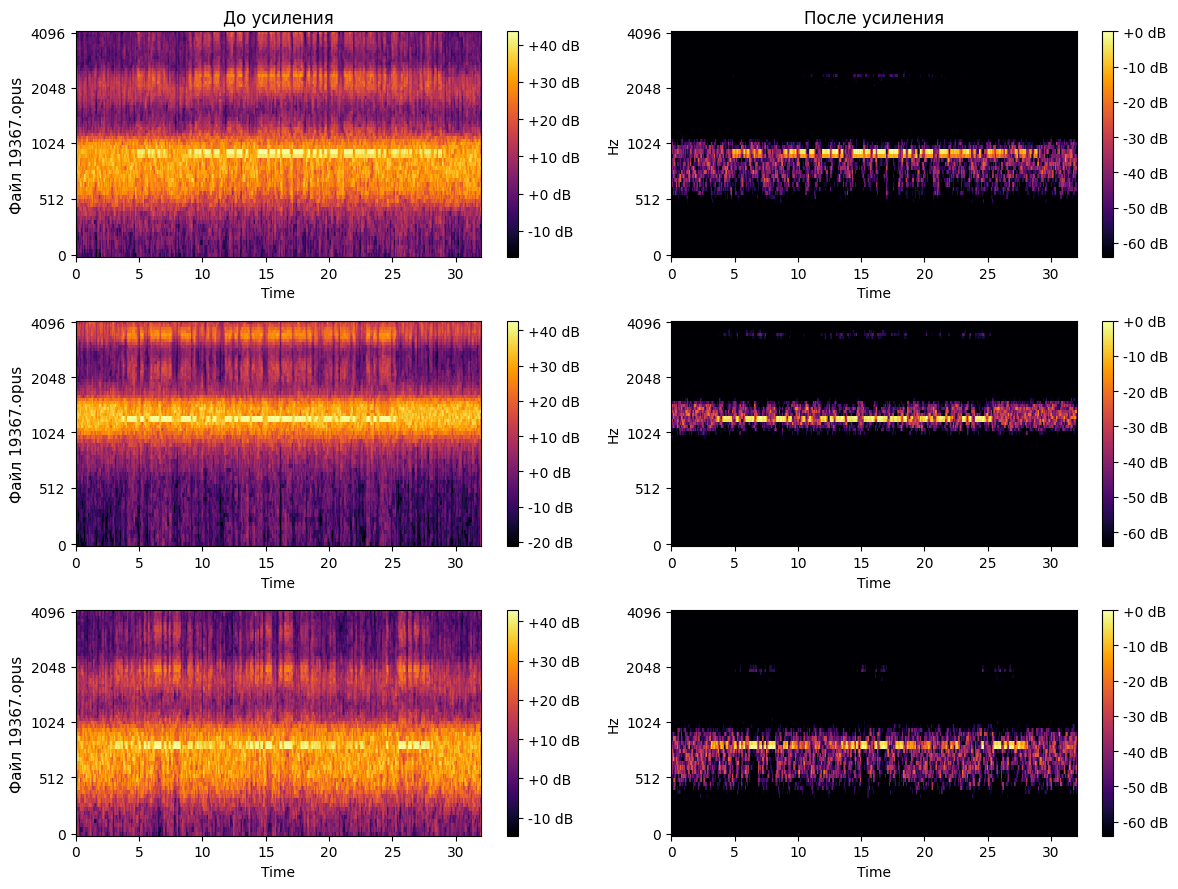

In [ ]:
plt.figure(figsize=(12, 9))

for i, file_id in enumerate(sample_train):
    waveform, sr = torchaudio.load(AUDIO_FILES_DIR / file_id)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64, f_max=4096
    )(waveform)

    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(mel).squeeze(0)

    boost_mel = mel**3.5
    boost_mel = boost_mel / boost_mel.max()
    boost_mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(boost_mel).squeeze(0)

    plt.subplot(3, 2, 2 * i + 1)
    ld.specshow(
        mel_db.numpy(), sr=sr, x_axis="time", y_axis="mel", fmax=4096, cmap=cmap
    )
    if i == 0:
        plt.title("До усиления")

    plt.colorbar(format="%+2.0f dB")
    plt.ylabel(f"Файл {key}.opus", fontsize=11)

    plt.subplot(3, 2, 2 * i + 2)
    ld.specshow(
        boost_mel_db.numpy(), sr=sr, x_axis="time", y_axis="mel", fmax=4096, cmap=cmap
    )
    if i == 0:
        plt.title("После усиления")
    plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()

Отлично! Мы значительно снизили уровень шума и выделили целевой сигнал. <br>
Далее можно заметить, что часть частотного диапазона, вероятно, не содержит полезной информации для распознавания. <br>
Чтобы это проверить, построим график средней мощности сигнала по каждому мел-бину и посмотрим, какие частотные области действительно участвуют в передаче полезного сигнала.

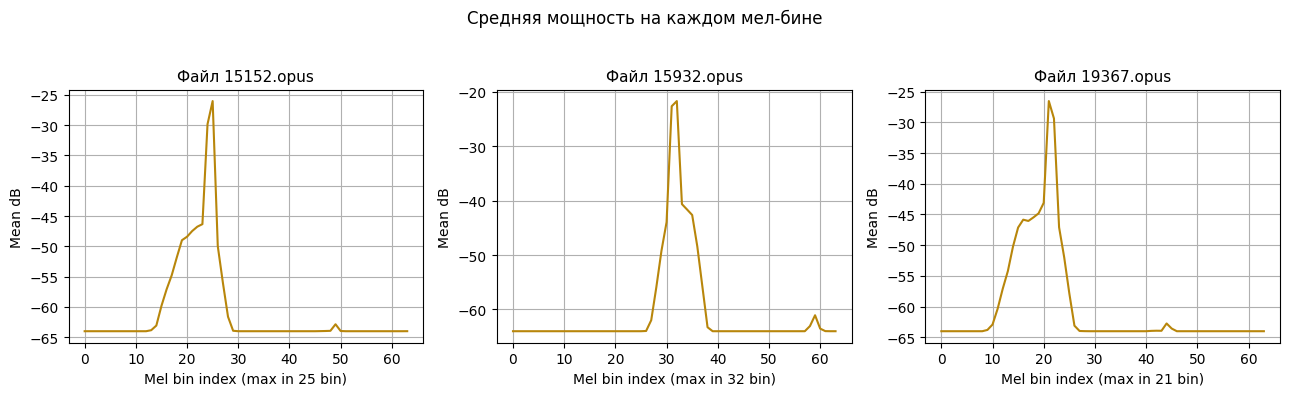

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
fig.suptitle("Средняя мощность на каждом мел-бине", fontsize=12)

for i, file_id in enumerate(sample_train):
    waveform, sr = torchaudio.load(AUDIO_FILES_DIR / file_id)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64, f_max=4096
    )(waveform)

    boost_mel = mel**3.5
    boost_mel = boost_mel / boost_mel.max()
    boost_mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(boost_mel).squeeze(0)

    mean_power_per_freq = boost_mel_db.mean(axis=1)

    axs[i].plot(
        mean_power_per_freq.numpy(),
        color="darkgoldenrod",
    )
    axs[i].set_title(f"Файл {file_id}", fontsize=11)
    axs[i].set_xlabel(f"Mel bin index (max in {np.argmax(mean_power_per_freq)} bin)")
    axs[i].set_ylabel("Mean dB")
    axs[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Анализ графика средней мощности показал, что наибольшая энергия сосредоточена в ограниченном диапазоне мел-частот, <br>
в то время как остальные бины содержат значительно меньше информации. <br>
**Чтобы сократить размерность признаков и оставить только наиболее информативные компоненты, сохраним по 10 мел-бинов по обе стороны от пикового значения.<br>
Это позволит сфокусироваться на наиболее важных частотах, убрав лишний шум.**

## Long files

Посмотрим на длинные аудио файлы

In [125]:
sample = np.random.randint(low=4987, high=4999, size=3)
sample_train = data["test"]["id"][sample]
sound_exmpls = {}

for i in sample_train:
    sound_exmpls[i[:-5]], sr = librosa.load((AUDIO_FILES_DIR / i), sr=8000)
    print(i, "sr =", sr)
    display(IPython.display.Audio(sound_exmpls[i[:-5]], rate=sr))

34995.opus sr = 8000


34989.opus sr = 8000


34995.opus sr = 8000


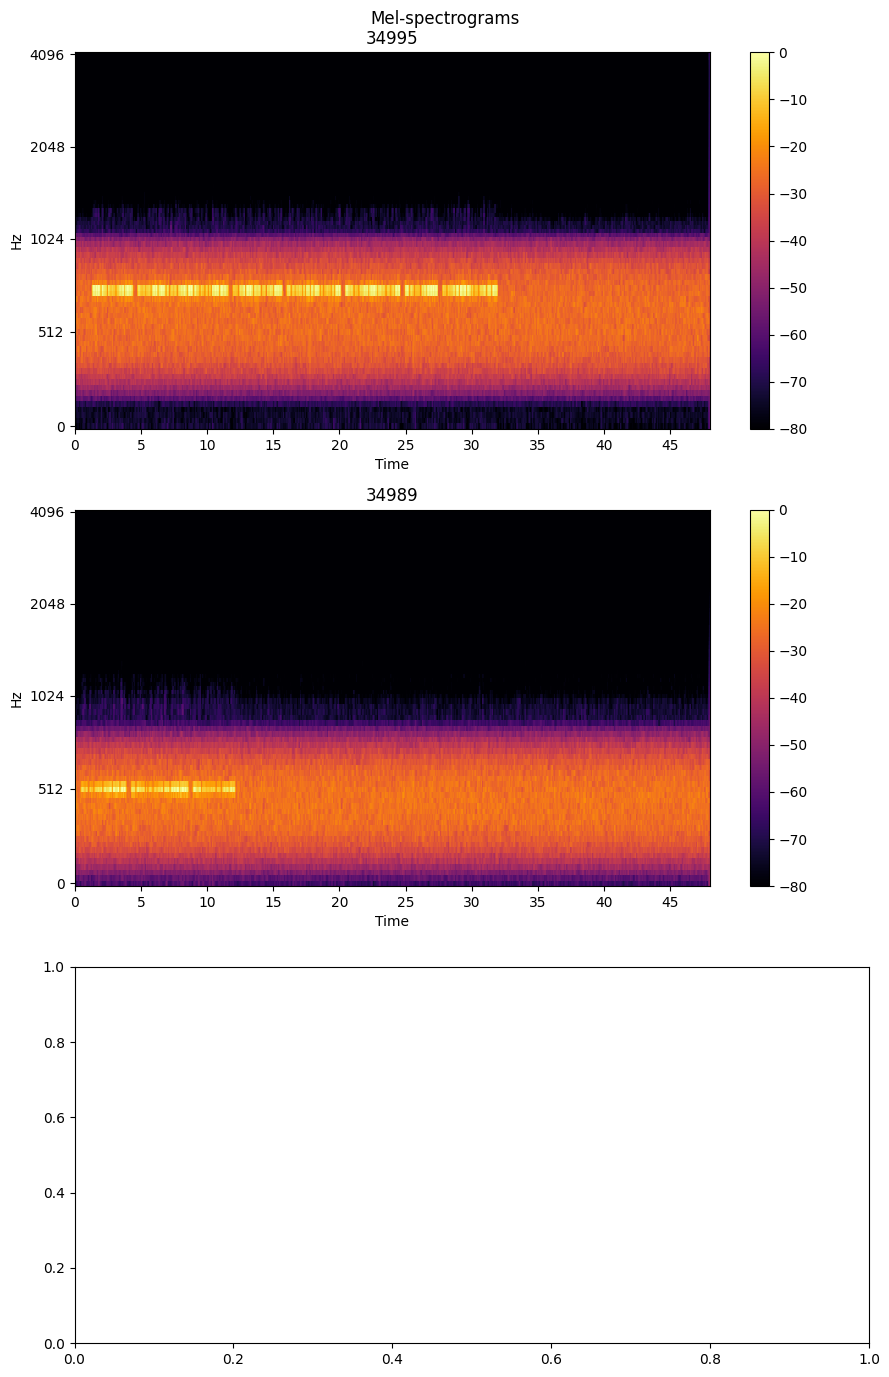

In [126]:
fig, axs = plt.subplots(3, 1, figsize=(9, 14))
fig.suptitle("Mel-spectrograms")
cmap = "inferno"

for i, (key, value) in enumerate(sound_exmpls.items()):
    ax = axs[i]

    S = librosa.feature.melspectrogram(y=value, sr=sr, n_mels=80, fmax=4096)
    S_dB = librosa.power_to_db(S, ref=np.max)

    img = ld.specshow(
        S_dB, sr=sr, x_axis="time", y_axis="mel", ax=ax, fmax=4096, cmap=cmap
    )
    fig.colorbar(img, ax=ax)
    ax.set_title(key)

fig.tight_layout()
plt.show()

В целом длинные аудиофайлы схожи с основными по характеру сигнала, однако имеют немного другие шумовые характеристики. <br>
Шум в них выглядит более плотным, без выраженных «отражений» и не растянут по широкому диапазону частот — <br>
он концентрируется в виде узкой и насыщенной полосы. <br>
Также на некоторых из этих файлов присутствует значительное количество пустых участков, где слышен только фоновый шум без целевого сигнала.